# Brain Tumor Detection

# 1. Introduction
In this notebook, I study whether or not deep learning methods can be used to detect brain tumors in MRI scan images.

The dataset is composed of 253 MRI brain scan images of various patients. Each image is labelled as either`yes` or `no`, depending on whether a brain tumor is present or not. All images are gray scale and they have mixed size formats.

It is worth noting that the two classes are not balanced, with the `yes` category accounting for around 63% of the total. This imbalance will be taken into account during model development.

To begin with, images are imported into the working directory and split into training, validation and test sets, respectively with ratios `0.7/0.2/0.1`.

In [1]:
# Install requirements
!pip install imutils
!pip install split_folders
!pip install visualkeras

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=1de5d2f7b10fbbe6dd6506367a7fc5bda3d65cbbee5a7ec4ab040752a8b96e56
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.3 MB/s eta 0:00:00


In [2]:
import os
import shutil
from copy import copy
import cv2
import imutils
import splitfolders
import visualkeras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D as GAP
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2

# Constants
TARGET_SIZE = (32, 32)
BATCH_SIZE = 32
SEED = 42

# Set random seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
## Import data to working directory and split into training, validation and testing sets

# Define paths to input and working data directories
input_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
data_path = '/kaggle/working/data'

# Delete working data dir if already exists
if os.path.exists(data_path):
    shutil.rmtree(data_path)
os.makedirs(data_path)

# Split images into training, validation and testing sets
splitfolders.ratio(input_path, data_path, seed=SEED, ratio=(0.7, 0.2, 0.1), group_prefix=None)

# Define paths for later use
train_path = f'{data_path}/train'
val_path = f'{data_path}/val'
test_path = f'{data_path}/test'

Copying files: 253 files [00:01, 205.99 files/s]


# 2. Exploratory Data Analysis
In this section, some exploratory data analysis (EDA) is performed on the MRI images.

First we look at a few examples from the training set, both for the tumor (`yes`) and no tumor (`no`) categories. We note that the tumor growths are quite visible in the `yes` images, giving us confidence that deep learning models will be able to identify such structures.

It is also worth noting that images seem to come in a variety of shape formats, which we will have to uniformise before feeding them to deep learning models. The minimum image width and height are, respectively, 168 and 150 pixels.

Finally, we note that images are not all cropped around the brain, but there are sometimes empty areas around it. This will be addressed in the next section.

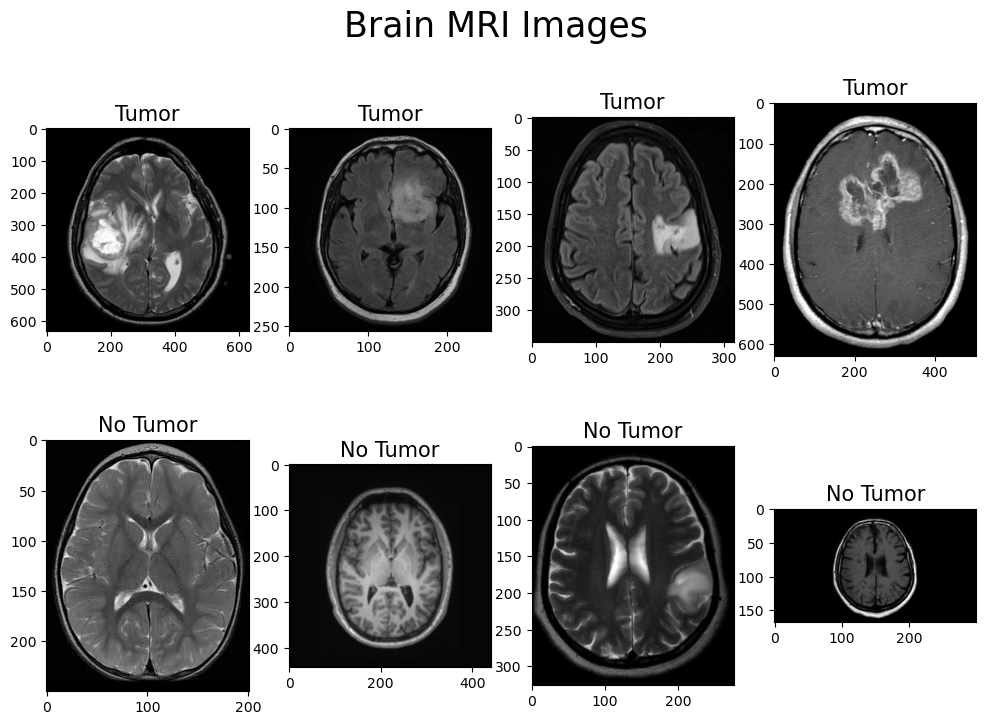

In [4]:
## Show example images
n_images = 4
fig, ax = plt.subplots(2, n_images, figsize=(12, 8))
fig.suptitle('Brain MRI Images', fontsize=25)
for i, class_name in enumerate(['yes', 'no']):
    source = f'{train_path}/{class_name}/'
    names = os.listdir(source)
    for j in range(n_images):    
        image = cv2.imread(f'{source}/{names[j]}')
        ax[i, j].imshow(image, cmap='gray')
        title = 'Tumor' if class_name == 'yes' else 'No Tumor'
        ax[i, j].set_title(title, fontsize=15)

In [5]:
## Collect shape information from all images
widths = []
heights = []
labels = []
for path in [train_path, val_path, test_path]:
    for class_name in ['yes', 'no']:
        source = f'{path}/{class_name}/'
        file_names = os.listdir(source)
        for name in file_names:
            img_src = str(source + name)       
            image = cv2.imread(img_src)
            widths.append(image.shape[0])
            heights.append(image.shape[1])
            labels.append(class_name)
            
df_dims = pd.DataFrame(
    {
        'Width': widths,
        'Height': heights,
        'Label': labels
    }
)

In [6]:
# Display image shape statistics
df_dims.describe()

,Width,Height
count,253.000000,253.000000
mean,386.019763,354.237154
std,213.128463,217.111684
min,168.000000,150.000000
25%,248.000000,225.000000
50%,331.000000,278.000000
75%,442.000000,400.000000
max,1427.000000,1920.000000


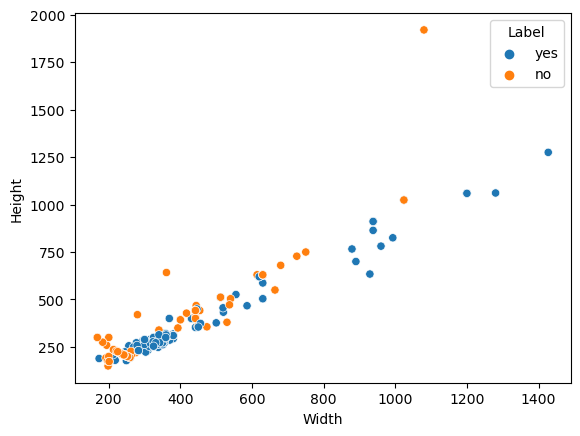

In [7]:
# Display scatter plot of image height and width
sns.scatterplot(df_dims, x='Width', y='Height', hue='Label');

# 3. Preprocessing

In this section, images are preprocessed to account for the disuniformity in shape dimensions and to crop the area representing the brain.

In [8]:
def reshape(image):
    '''
    Reshape image to 2D grayscale.
    '''
    output = copy(image)
    if len(output.shape) == 3:
        # If shape is (x, y, 1), squeeze last dimension
        if output.shape[2] == 1:
            output = np.squeeze(output, axis=-1)
        # If shape is (x, y, 3), make it grayscale
        elif output.shape[2] == 3:
            output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
        # If shape is (x, y, 4), discard last dimension
        # (only populated by value 1). Other values are 
        # normalised, so convert them into [0, 255] range.
        # Then convert to grayscale.
        elif output.shape[2] == 4:
            output = output[:, :, :-1]*255
            output = output.astype(np.uint8)
            output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    return output


def crop_image(image, add_pixels=0):
    """
    Finds the extreme points on the image and crops it.
    """
    output = copy(image)
    blurred = cv2.GaussianBlur(output, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh = np.array(thresh, dtype=np.uint8)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    output = output[
        extTop[1] - add_pixels : extBot[1] + add_pixels,
        extLeft[0] - add_pixels : extRight[0] + add_pixels
    ]
    output = np.array(output)
    return output

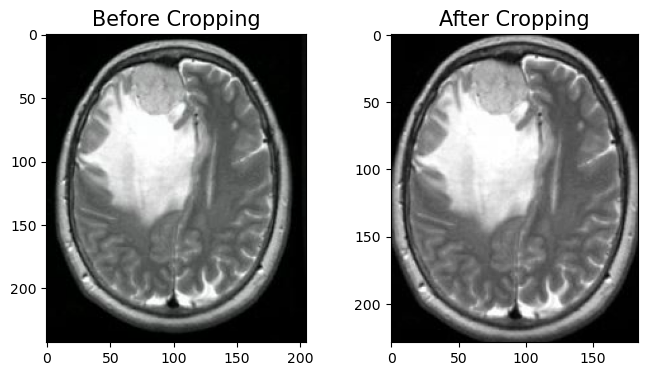

In [9]:
## The effect of cropping is shown on an example image from the training set
image_path = f'{train_path}/yes/Y65.JPG'
image_before = cv2.imread(image_path)
image_after = reshape(image_before)
image_after = crop_image(image_after)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image_before, cmap='gray')
ax[0].set_title('Before Cropping', fontsize=15)
ax[1].imshow(image_after, cmap='gray')
ax[1].set_title('After Cropping', fontsize=15);

In [10]:
## Preprocess all images
for path in [train_path, val_path, test_path]:
    for class_name in ['yes', 'no']:
        source = f'{path}/{class_name}'
        names = os.listdir(source)
        for name in names:
            img_path = f'{source}/{name}'
            image = cv2.imread(img_path)
            image = reshape(image)
            image = crop_image(image)
            cv2.imwrite(img_path, image)

# 4. Modelling
In this section, three different models are built and tested:
1. CNN
2. CNN + Data Augmentation
3. Transfer Learning (ResNet50V2)

In [11]:
## Define plotting functions for model evaluation

def plot_history(history, ax=None):
    df = pd.DataFrame(history.history)
    df = df.rename(
        columns={
            'loss': 'Training Loss',
            'accuracy': 'Training Accuracy',
            'val_loss': 'Validation Loss',
            'val_accuracy': 'Validation Accuracy'
        }
    )
    if ax is None:
        fig, ax = plt.subplots()
    df.plot(ax=ax)
    ax.set_xlabel('Epoch')
    return ax


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm , index=['0', '1'] , columns=['0', '1'])

    plt.figure(figsize = (6,5))
    sns.heatmap(
        cm, cmap='Blues', linecolor='black',
        linewidth=1 , annot=True, fmt='',
        xticklabels = ['Predicted Normal', 'Predicted Tumor'],
        yticklabels = ['Actual Normal', 'Actual Tumor']
    )
    plt.yticks(rotation=0)
    plt.show()

## Model 1: CNN

The first model is a Convolutional Neural Network (CNN). The model complexity is kept low to prevent overfitting, given the very small number of training examples.

Images are loaded via Image Data Generators and rescaled so that each input is between 0 and 1. Images are also resized to be 32x32.

The class imbalance is accounted for by weighting the two classes differently during training. This is done via the `class_weight` parameter of the `model.fit()` method.

In [12]:
# ImageDataGenerator for training images
train_gen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for validation and testing images
test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)

Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [13]:
## Compute class weight to address class unbalance problem
y_train_labels = train_set.classes
class_weight_list = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
CLASS_WEIGHT = dict(zip(np.unique(y_train_labels), class_weight_list))
print(CLASS_WEIGHT)

{0: 1.2941176470588236, 1: 0.8148148148148148}


In [14]:
## Define first model
model1 = Sequential(
    [
        Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=TARGET_SIZE + (1,)),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=8, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=4, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 4)           292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 4)          0

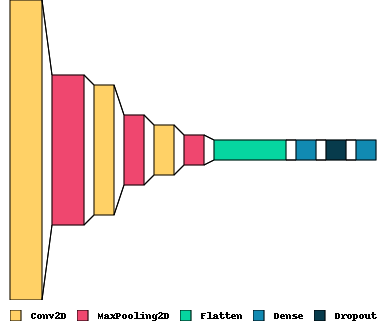

In [15]:
# Show a schematic representation of the model
visualkeras.layered_view(model1, legend=True, draw_volume=False, scale_xy=10, scale_z=2)

In [16]:
model1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-5),
    metrics=['accuracy']
)

In [17]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=30
)

In [18]:
history1 = model1.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)

Epoch 1/100
6/6 [==============================] - 2s 87ms/step - loss: 0.6986 - accuracy: 0.3864 - val_loss: 0.6986 - val_accuracy: 0.4000
Epoch 2/100
6/6 [==============================] - 0s 55ms/step - loss: 0.6933 - accuracy: 0.4830 - val_loss: 0.6926 - val_accuracy: 0.5400
Epoch 3/100
6/6 [==============================] - 0s 60ms/step - loss: 0.6936 - accuracy: 0.5568 - val_loss: 0.6928 - val_accuracy: 0.5800
Epoch 4/100
6/6 [==============================] - 0s 55ms/step - loss: 0.6928 - accuracy: 0.6250 - val_loss: 0.6925 - val_accuracy: 0.5800
Epoch 5/100
6/6 [==============================] - 0s 57ms/step - loss: 0.6928 - accuracy: 0.6307 - val_loss: 0.6919 - val_accuracy: 0.5800
Epoch 6/100
6/6 [==============================] - 0s 52ms/step - loss: 0.6929 - accuracy: 0.6250 - val_loss: 0.6913 - val_accuracy: 0.6200
Epoch 7/100
6/6 [==============================] - 0s 51ms/step - loss: 0.6925 - accuracy: 0.6364 - val_loss: 0.6912 - val_accuracy: 0.6200
Epoch 8/100
6/6 [===

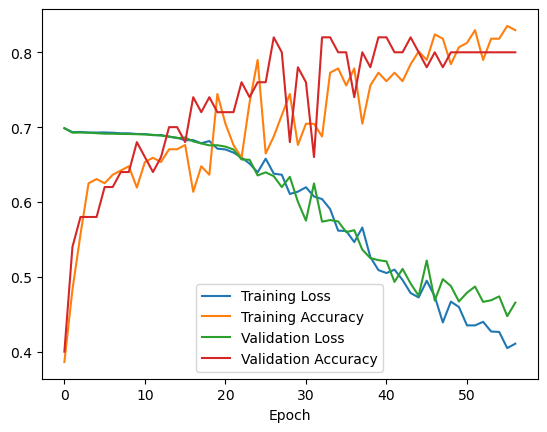

In [19]:
plot_history(history1);

In [20]:
y_true = test_set.classes
y_prob = model1.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 0s 182ms/step


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.92      0.75      0.83        16

    accuracy                           0.81        27
   macro avg       0.82      0.83      0.81        27
weighted avg       0.84      0.81      0.82        27



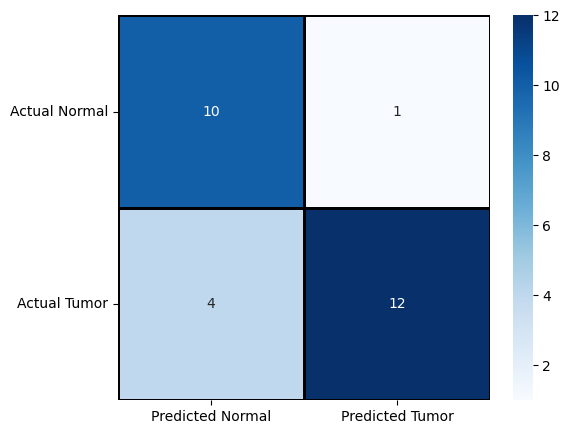

In [22]:
plot_confusion_matrix(y_true, y_pred)

## Model 2: CNN + Data Augmentation

The second model is very similar to the first, but this time we perform some data augmentation. Augmented images are obtained by randomly rotating training images in a 10 degree range, as well as horizontally and vertically flipping them.

In [23]:
# Data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)

Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [24]:
## Define second model
model2 = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=TARGET_SIZE + (1,)),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=16, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=8, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 8)           1160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 8)         

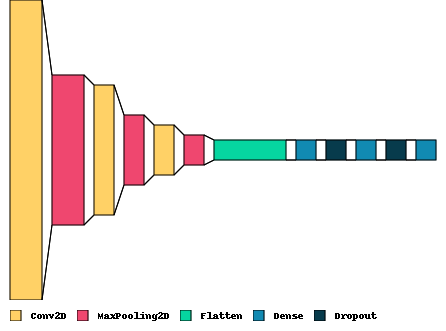

In [25]:
# Show a schematic representation of the model
visualkeras.layered_view(model2, legend=True, draw_volume=False, scale_xy=10, scale_z=1)

In [26]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-6),
    metrics=['accuracy']
)

In [27]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=40
)

In [28]:
history2 = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)

Epoch 1/100
6/6 [==============================] - 2s 115ms/step - loss: 0.6926 - accuracy: 0.6080 - val_loss: 0.6698 - val_accuracy: 0.6200
Epoch 2/100
6/6 [==============================] - 0s 67ms/step - loss: 0.6914 - accuracy: 0.5966 - val_loss: 0.6635 - val_accuracy: 0.6200
Epoch 3/100
6/6 [==============================] - 0s 64ms/step - loss: 0.6876 - accuracy: 0.5966 - val_loss: 0.6654 - val_accuracy: 0.6200
Epoch 4/100
6/6 [==============================] - 0s 64ms/step - loss: 0.7015 - accuracy: 0.6023 - val_loss: 0.6707 - val_accuracy: 0.6200
Epoch 5/100
6/6 [==============================] - 0s 62ms/step - loss: 0.6909 - accuracy: 0.5966 - val_loss: 0.6811 - val_accuracy: 0.6200
Epoch 6/100
6/6 [==============================] - 0s 63ms/step - loss: 0.6908 - accuracy: 0.5739 - val_loss: 0.6791 - val_accuracy: 0.6200
Epoch 7/100
6/6 [==============================] - 0s 61ms/step - loss: 0.6875 - accuracy: 0.6477 - val_loss: 0.6724 - val_accuracy: 0.6200
Epoch 8/100
6/6 [==

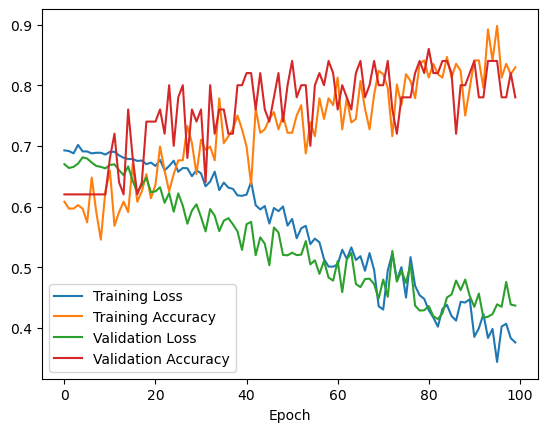

In [29]:
plot_history(history2);

In [30]:
y_true = test_set.classes
y_prob = model2.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 0s 159ms/step


In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.93      0.81      0.87        16

    accuracy                           0.85        27
   macro avg       0.85      0.86      0.85        27
weighted avg       0.86      0.85      0.85        27



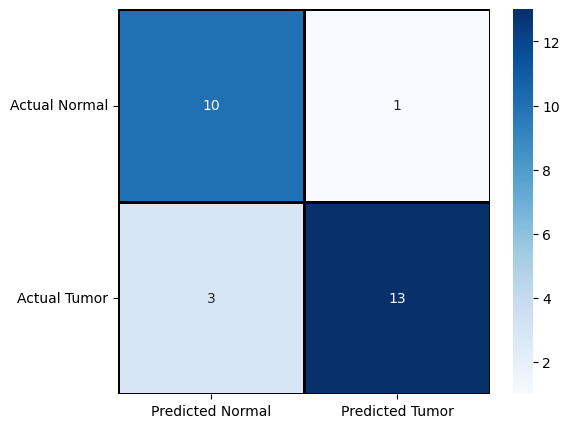

In [32]:
plot_confusion_matrix(y_true, y_pred)

## Model 3: Transfer Learning - ResNet50V2

For third and last model we use transfer learning. The pre-trained `ResNet50V2` model is chosen as base model, with frozen weights. To this, we add a GlobalAveragePooling2D layer and two Dense layers with 32 neurons and 20% dropout. This model is also trained on the augmented dataset.

In [33]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=SEED
)

val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    seed=SEED
)

Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [34]:
# Define ResNet model and freeze weights
base_model = ResNet50V2(input_shape=TARGET_SIZE + (3,), include_top=False)
base_model.trainable = False

# Define third model
model3 = Sequential(
    [
        base_model, 
        GAP(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model3.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                

In [35]:
model3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-5),
    metrics=['accuracy']
)

In [36]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=30
)

In [37]:
history3 = model3.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)

Epoch 1/100
6/6 [==============================] - 6s 338ms/step - loss: 0.6963 - accuracy: 0.6193 - val_loss: 0.5867 - val_accuracy: 0.6600
Epoch 2/100
6/6 [==============================] - 1s 115ms/step - loss: 0.6415 - accuracy: 0.6761 - val_loss: 0.6040 - val_accuracy: 0.6800
Epoch 3/100
6/6 [==============================] - 1s 138ms/step - loss: 0.6189 - accuracy: 0.6761 - val_loss: 0.6169 - val_accuracy: 0.6200
Epoch 4/100
6/6 [==============================] - 1s 154ms/step - loss: 0.6323 - accuracy: 0.6705 - val_loss: 0.6158 - val_accuracy: 0.6200
Epoch 5/100
6/6 [==============================] - 1s 148ms/step - loss: 0.5927 - accuracy: 0.7045 - val_loss: 0.5929 - val_accuracy: 0.6600
Epoch 6/100
6/6 [==============================] - 1s 131ms/step - loss: 0.5714 - accuracy: 0.7045 - val_loss: 0.5614 - val_accuracy: 0.7200
Epoch 7/100
6/6 [==============================] - 1s 116ms/step - loss: 0.5442 - accuracy: 0.7102 - val_loss: 0.5390 - val_accuracy: 0.7400
Epoch 8/100
6

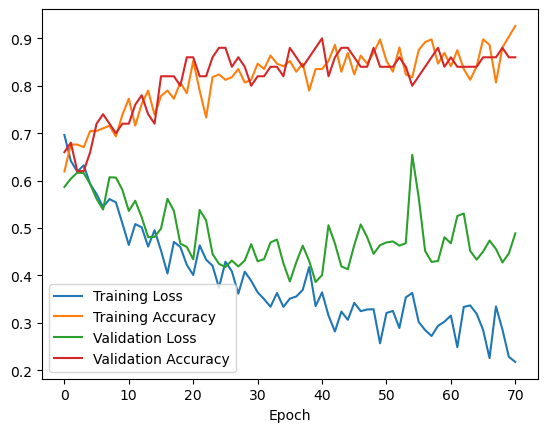

In [38]:
plot_history(history3);

In [39]:
y_true = test_set.classes
y_prob = model3.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 1s 1s/step


In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.80      0.75      0.77        16

    accuracy                           0.74        27
   macro avg       0.73      0.74      0.73        27
weighted avg       0.75      0.74      0.74        27



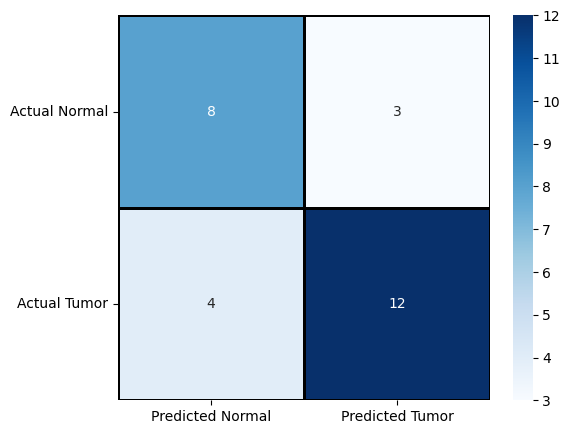

In [41]:
plot_confusion_matrix(y_true, y_pred)

# 5. Conclusions
In this notebook, we prove that deep learning models can be used to identify brain tumors from MRI scans to a good level of accuracy.

Among the three models, the second is the one achieving the best performance on the test set. Data augmentation allows the model to generalise better, achieving a test accuracy of 85%. Additionally, the second model has the highest recall (81%), and hence the lowest amount of false negatives. This is highly desirable, since false negatives are very dangerous in healthcare applications.

The models presented in this notebook can be further improved by tuning their hyperparameters and reduce the slight overfitting that is observed in some cases. Furthermore, in order to speed up training, the size of the images was reduced down to 32x32. Experimenting with higher image sizes might improve performance by allowing models to learn more fine-grain detail. Finally, the small size of the dataset reprents an important limitation to the ability of models to learn the general features that characterise the two classes of images.